In [2]:
from data_tools.api import *
from utilscht.Data import *
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import statsmodels.api as sm
from joblib import Parallel,delayed
import datetime
from scipy.interpolate import interp1d
import logging
%config InlineBackend.figure_format ='retina'
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


START_YEAR=2015
plt.rcParams['figure.figsize']=(8,6)
plt.rcParams['font.size']=10
pd.set_option("precision",4)

DB_INFO = dict(host='192.168.1.234',
               user='winduser',
               password='1qaz@WSX',
               db='wind')

conn = pymysql.connect(**DB_INFO, charset='utf8mb4', cursorclass=pymysql.cursors.DictCursor)

In [3]:
logging.basicConfig(level=logging.DEBUG,#控制台打印的日志级别
                    filename=r'logging/Con_expect_Strategy.log',
                    filemode='a',##模式，有w和a，w就是写模式，每次都会重新写日志，覆盖之前的日志
                    #a是追加模式，默认如果不写的话，就是追加模式
                    format='%(asctime)s - %(pathname)s[line:%(lineno)d] - %(levelname)s: %(message)s'#日志格式
                   )

In [4]:
def apply_parallel(df_grouped, func, n_jobs=16, backend='loky', as_index=True, **kwargs):
    """
    This is for parallel between grouped generated by pd.DataFrame.groupby
    :param df_grouped:
    :param func:
    :param n_jobs:
    :param backend:
    :param kwargs:
    :return:
    """

    names = []
    groups = []
    for name, group in df_grouped:
        names.append(name)
        groups.append(group)

    results = Parallel(n_jobs=n_jobs, verbose=5, backend=backend, batch_size='auto') \
        (delayed(func)(group, **kwargs) for group in groups)

    return pd.concat(results, keys=names if as_index else None)

## 选取沪深300 基本面较好的股票

In [21]:
"""df_top_comp = pd.read_csv(r"../tempory task/result/Top_stocks_each_indus.csv",index_col="Unnamed: 0")
df_top_comp = df_top_comp[(0.05<=df_top_comp["BarraSGRO"]) & (0.05<=df_top_comp["BarraEGRO"]) &(df_top_comp["BarraSGRO"]<=0.5) &(df_top_comp["BarraEGRO"]<=0.5)]
stk_ls= df_top_comp.sid

df_hs300=query_table("DailyBar",start_date='20190506',end_date='20190506',fields=["w_hs300"])
stk_hs300 = df_hs300[df_hs300["w_hs300"]!=0].sid

stk_ls=list(set(stk_ls) & set(stk_hs300))"""

stk_ls = \
["000001.SZ","000002.SZ",
"000333.SZ","000538.SZ",
"000568.SZ","000651.SZ",
"000661.SZ","000858.SZ",
"002032.SZ","002050.SZ",
"002142.SZ","002179.SZ",
"002311.SZ","002415.SZ",
"002475.SZ","300003.SZ",
"300015.SZ","300124.SZ",
"600009.SH","600036.SH",
"600048.SH","600104.SH",
"600176.SH","600196.SH",
"600276.SH","600309.SH",
"600332.SH","600340.SH",
"600406.SH","600436.SH",
"600438.SH","600487.SH",
"600498.SH","600519.SH",
"600522.SH","600585.SH",
"600588.SH","600660.SH",
"600690.SH","600741.SH",
"600809.SH","600887.SH",
"601166.SH","601155.SH",
"601318.SH","601607.SH",
"601668.SH","601877.SH",
"601888.SH","601933.SH",
"603160.SH","603288.SH",
]

#获取一致预期数据
con_expect_data=pd.read_csv(r"result/con_eps_my_v3.csv",dtype={"DataDate":str,"REPORTING_PERIOD":str})
con_expect_data=con_expect_data.groupby(["sid","REPORTING_PERIOD"],as_index=False)\
                    .apply(lambda x:x.replace(0,np.nan).fillna(method="ffill"))
open_price_adj=pd.read_csv(r"data/open_price.csv",dtype={"DataDate":str})
con_expect_data=con_expect_data[["sid","REPORTING_PERIOD","DataDate","con_est_eps"]]

stock_pool_est_eps=con_expect_data.set_index("sid")#.loc[stk_ls]
stock_pool_est_eps=stock_pool_est_eps[stock_pool_est_eps["DataDate"]>"{}1101".format(START_YEAR)].reset_index()

#加入收盘价序列
df_close=pd.read_csv(r"data/close_price.csv",dtype={"DataDate":str})

stock_pool_est_eps=pd.merge(stock_pool_est_eps,df_close,on=["sid","DataDate"],how="left")

'df_top_comp = pd.read_csv(r"../tempory task/result/Top_stocks_each_indus.csv",index_col="Unnamed: 0")\ndf_top_comp = df_top_comp[(0.05<=df_top_comp["BarraSGRO"]) & (0.05<=df_top_comp["BarraEGRO"]) &(df_top_comp["BarraSGRO"]<=0.5) &(df_top_comp["BarraEGRO"]<=0.5)]\nstk_ls= df_top_comp.sid\n\ndf_hs300=query_table("DailyBar",start_date=\'20190506\',end_date=\'20190506\',fields=["w_hs300"])\nstk_hs300 = df_hs300[df_hs300["w_hs300"]!=0].sid\n\nstk_ls=list(set(stk_ls) & set(stk_hs300))'

## 如何确定合理pe
1. 个股过去两年pe—ttm中位数 0.5
2. 行业当前pe水平 0.3
3. 行业pe过去两年中位数 0.2

In [ ]:
temp_df = df_PETTM_2y_rollingmedian[df_PETTM_2y_rollingmedian["sid"]=="000655.SZ"]
plt.plot(pd.to_datetime(temp_df["DataDate"]),
    temp_df["pe_2y_rollingmedian"].values)
plt.plot(pd.to_datetime(temp_df["DataDate"]),
    temp_df["S_VAL_PE_TTM"].values)

In [32]:
df_PETTM.columns

Index(['sid', 'DataDate', 'S_VAL_PE_TTM', 'S_DQ_MV', 'L1_INDUSTRY'], dtype='object')

In [45]:
groups = df_PETTM.groupby(["L1_INDUSTRY","DataDate"])
get_indus_pe_median = lambda x: pd.DataFrame(data=[[np.nanmedian(x["S_VAL_PE_TTM"]),x["L1_INDUSTRY"].iloc[0],x["DataDate"].iloc[0]]],\
                                             columns=["indus_pe_meidna","industry","DataDate"])
get_indus_pe_mean = lambda x: pd.DataFrame(data=[[np.nanmean(x["S_VAL_PE_TTM"]),x["L1_INDUSTRY"].iloc[0],x["DataDate"].iloc[0]]],\
                                             columns=["indus_pe_mean","industry","DataDate"])
df_indus_pe_median = apply_parallel(groups, get_indus_pe_median,as_index=True).reset_index(drop=True)
df_indus_pe_mean = apply_parallel(groups, get_indus_pe_mean,as_index=True).reset_index(drop=True)
df_indus_pe_median
df_indus_pe_mean

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    4.8s
[Parallel(n_jobs=16)]: Done 196 tasks      | elapsed:    5.8s
[Parallel(n_jobs=16)]: Done 448 tasks      | elapsed:    7.1s
[Parallel(n_jobs=16)]: Done 772 tasks      | elapsed:    8.5s
[Parallel(n_jobs=16)]: Done 1168 tasks      | elapsed:   10.7s
[Parallel(n_jobs=16)]: Done 1800 tasks      | elapsed:   12.7s
[Parallel(n_jobs=16)]: Done 2880 tasks      | elapsed:   15.7s
[Parallel(n_jobs=16)]: Done 4104 tasks      | elapsed:   19.7s
[Parallel(n_jobs=16)]: Done 5472 tasks      | elapsed:   25.2s
[Parallel(n_jobs=16)]: Done 6984 tasks      | elapsed:   31.6s
[Parallel(n_jobs=16)]: Done 8640 tasks      | elapsed:   38.5s
[Parallel(n_jobs=16)]: Done 10440 tasks      | elapsed:   44.9s
[Parallel(n_jobs=16)]: Done 12384 tasks      | elapsed:   49.3s
[Parallel(n_jobs=16)]: Done 14472 tasks      | elapsed:   56.8s
[Parallel(n_jobs=16)]: Done 16704 tasks   

indus_pe_meidna  industry  DataDate
0                  NaN         0  20130104
1                  NaN         0  20130107
2                  NaN         0  20130108
3                  NaN         0  20130109
4                  NaN         0  20130110
...                ...       ...       ...
52052          34.6524        30  20200304
52053          35.9440        30  20200305
52054          35.4683        30  20200306
52055          34.2114        30  20200309
52056          35.3311        30  20200310

[52057 rows x 3 columns]

indus_pe_mean  industry  DataDate
0                NaN         0  20130104
1                NaN         0  20130107
2                NaN         0  20130108
3                NaN         0  20130109
4                NaN         0  20130110
...              ...       ...       ...
52052        39.6723        30  20200304
52053        41.2715        30  20200305
52054        40.6860        30  20200306
52055        39.2368        30  20200309
52056        40.2057        30  20200310

[52057 rows x 3 columns]

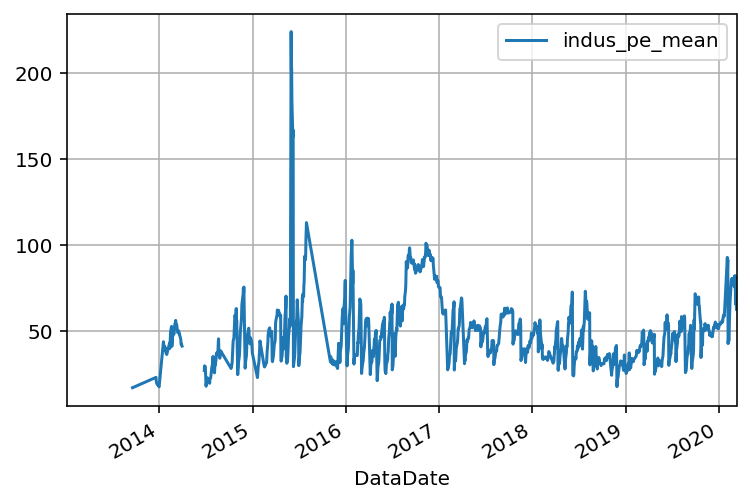

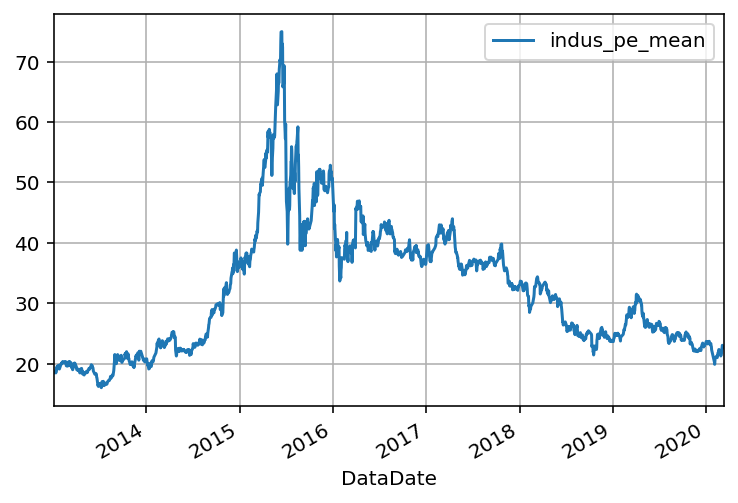

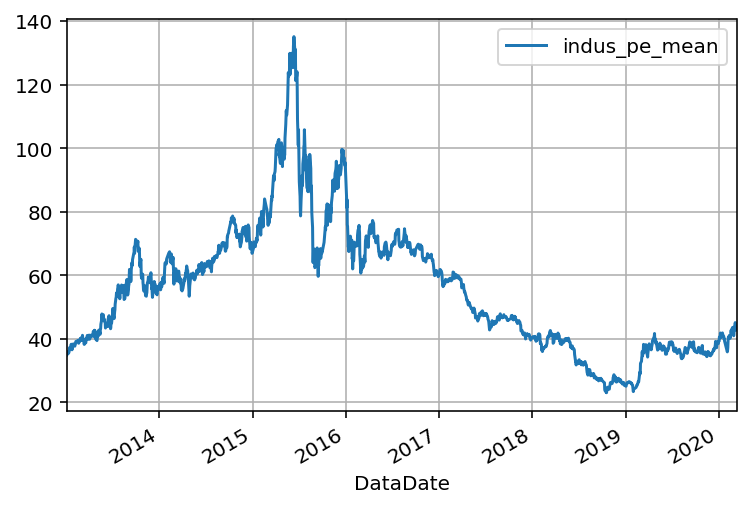

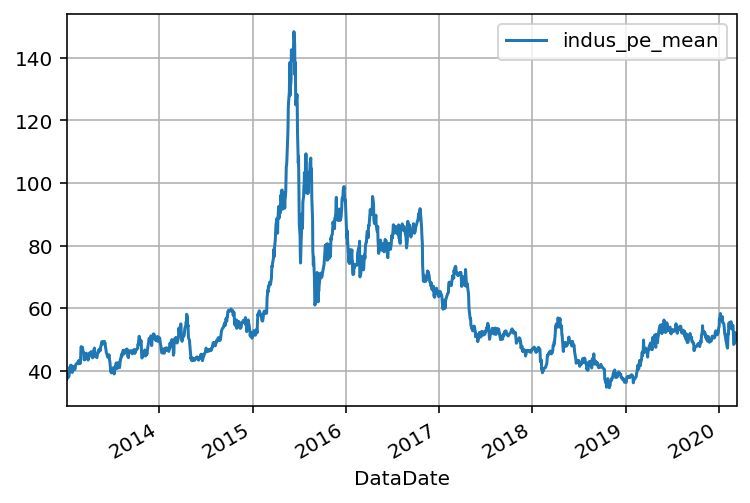

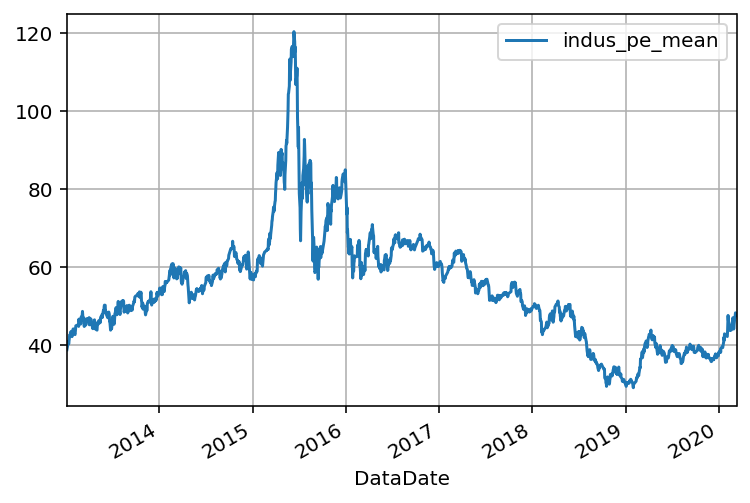

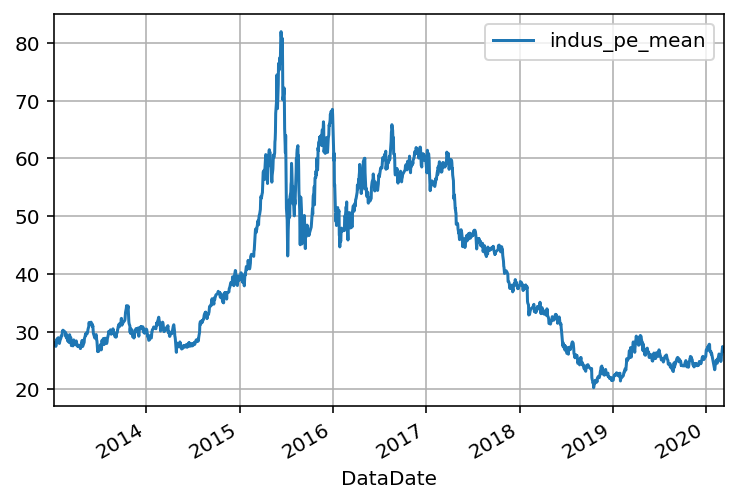

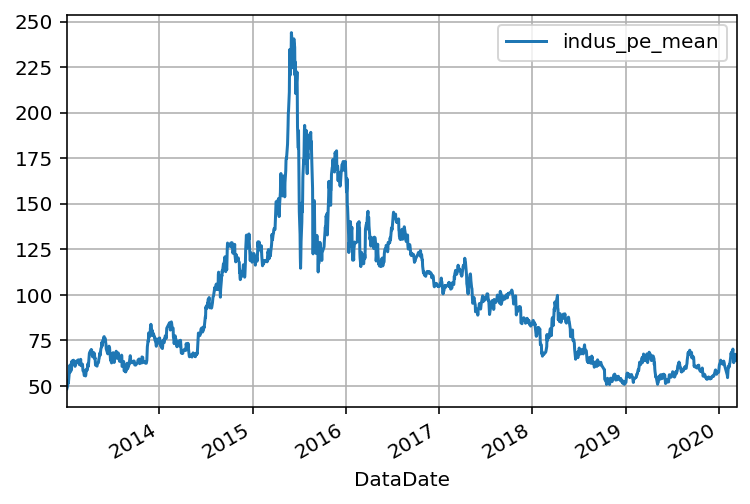

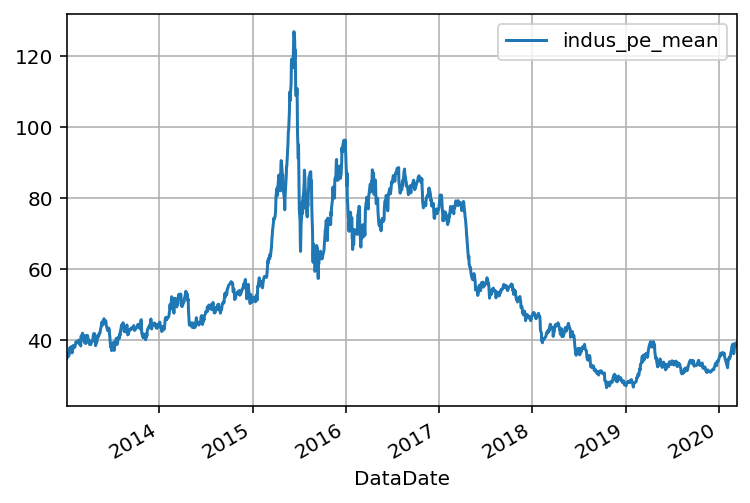

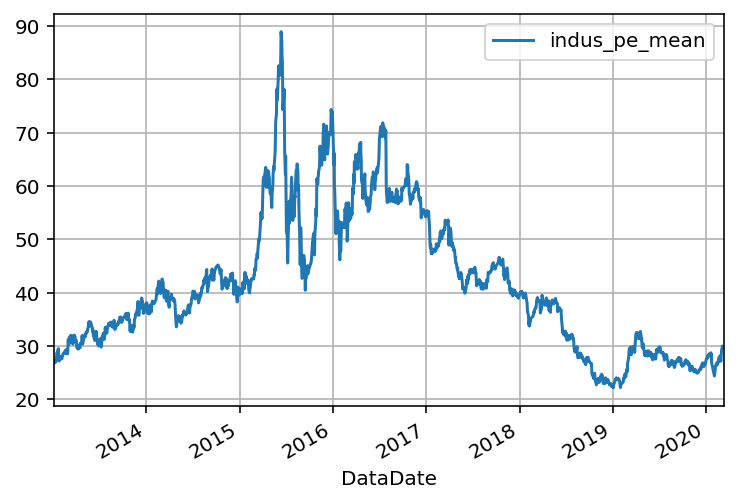

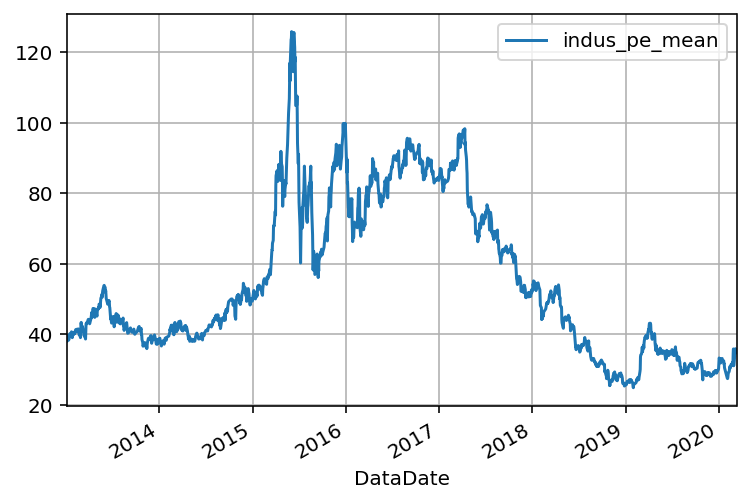

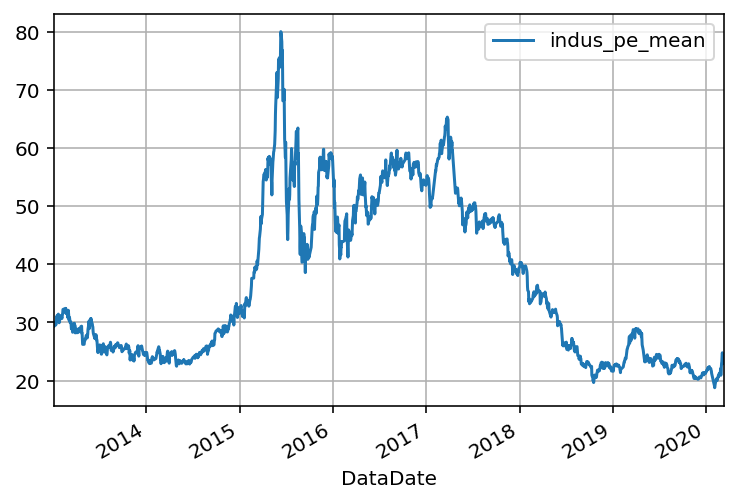

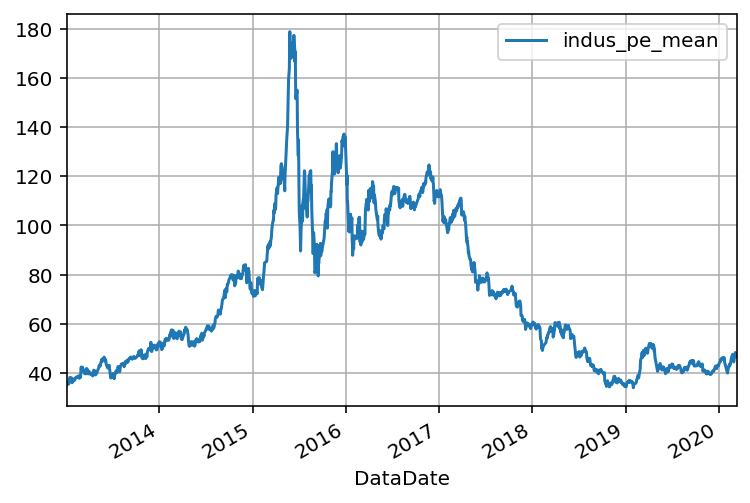

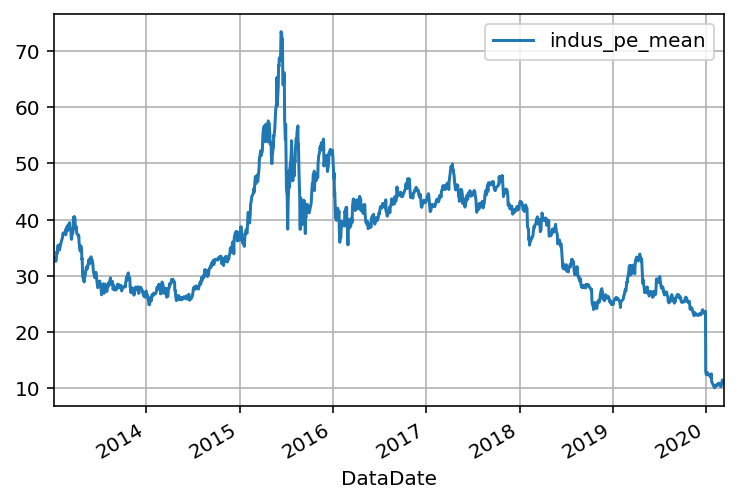

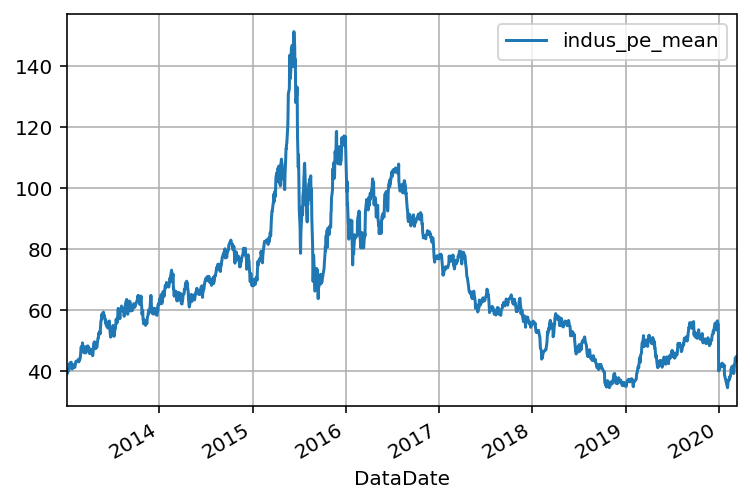

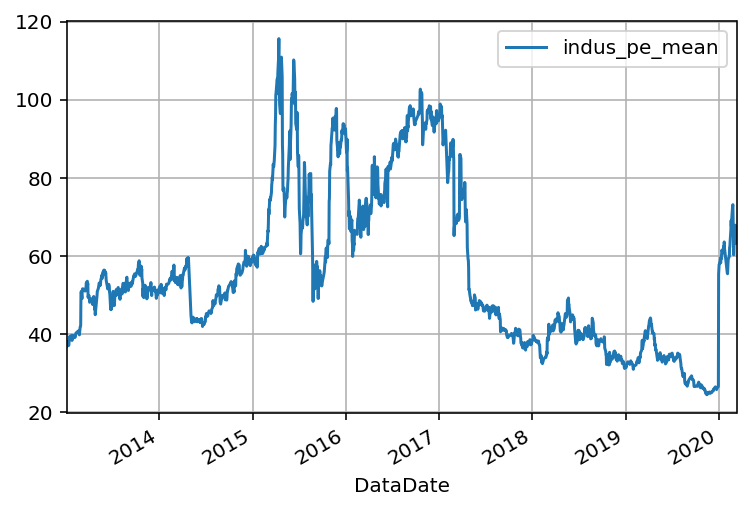

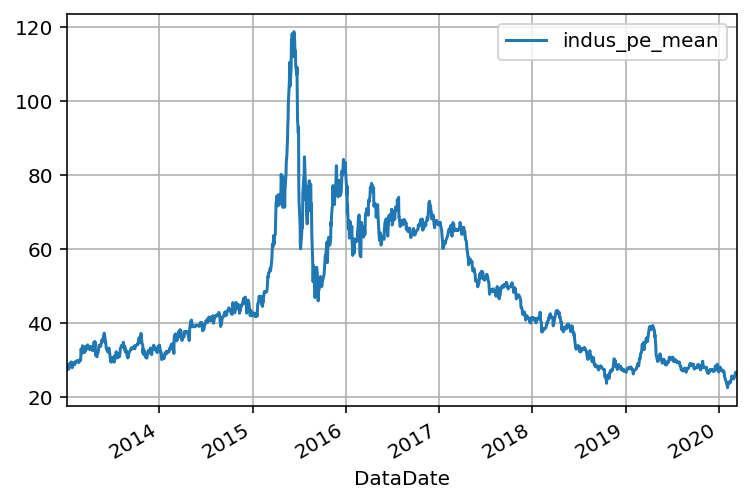

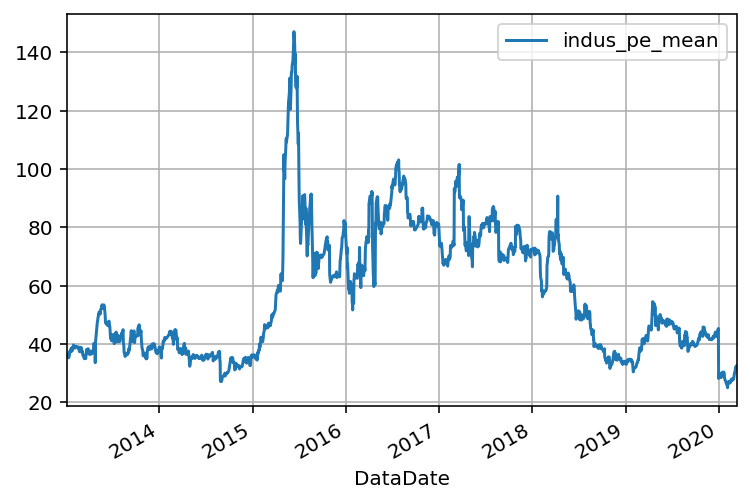

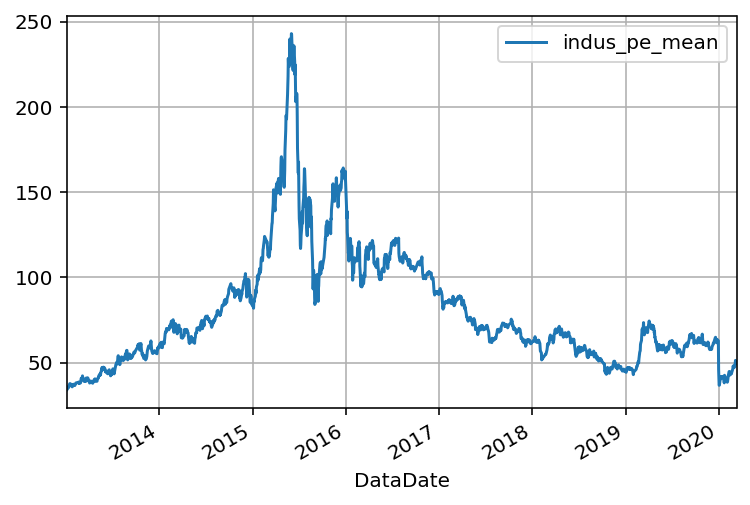

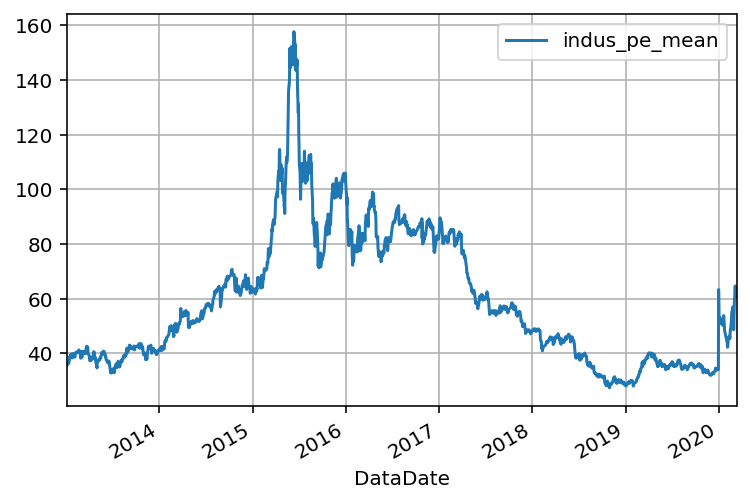

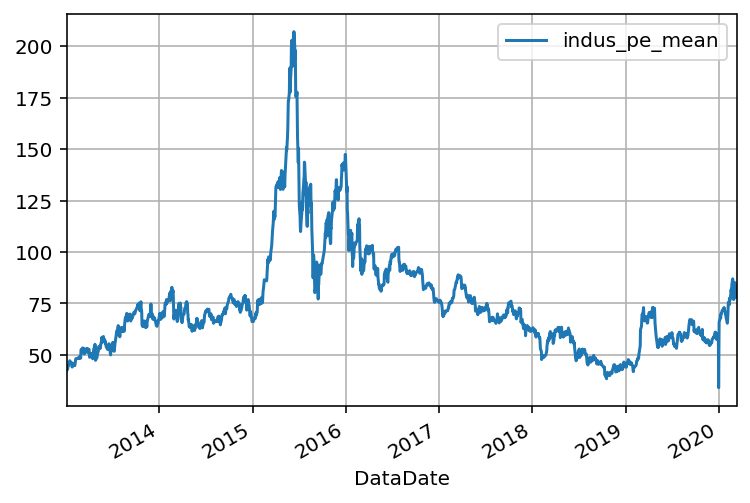

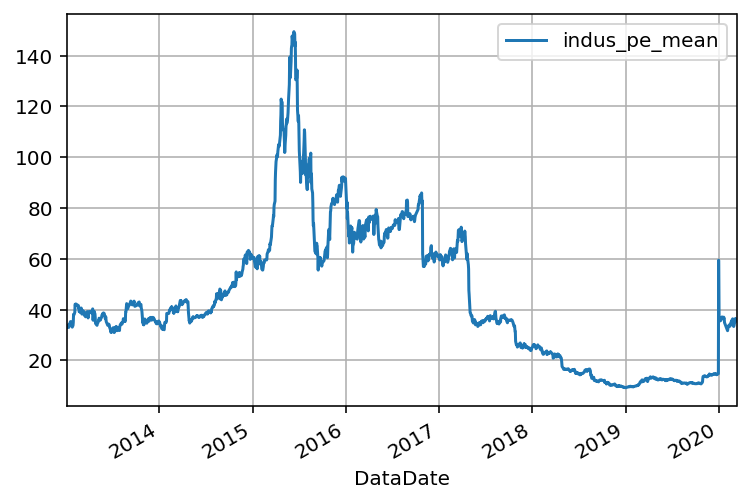

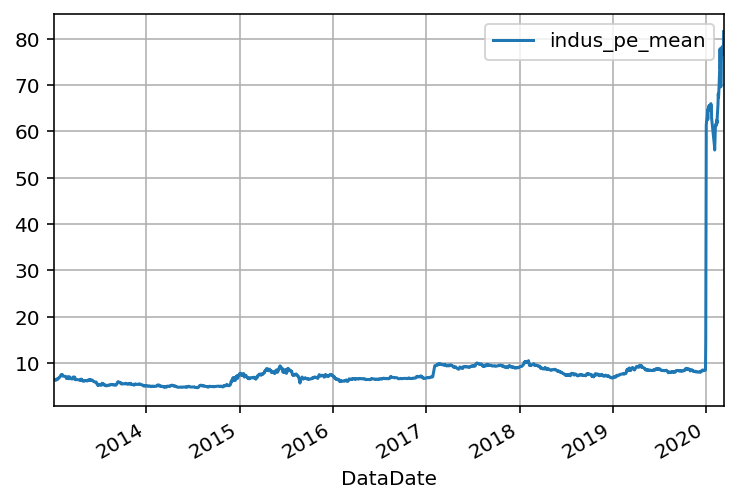

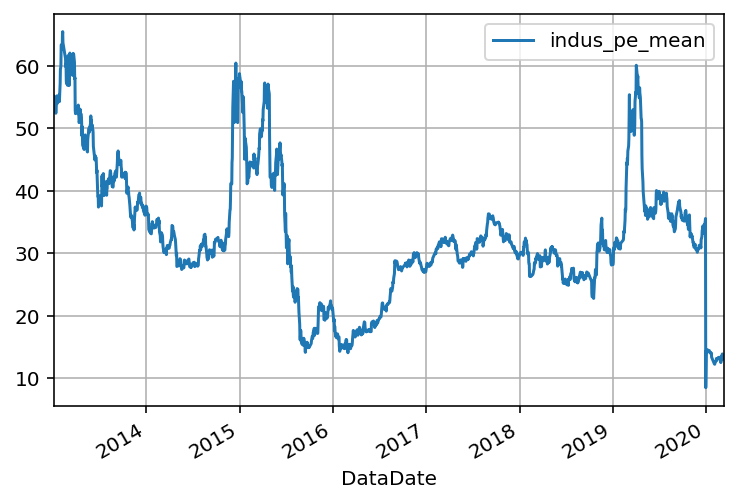

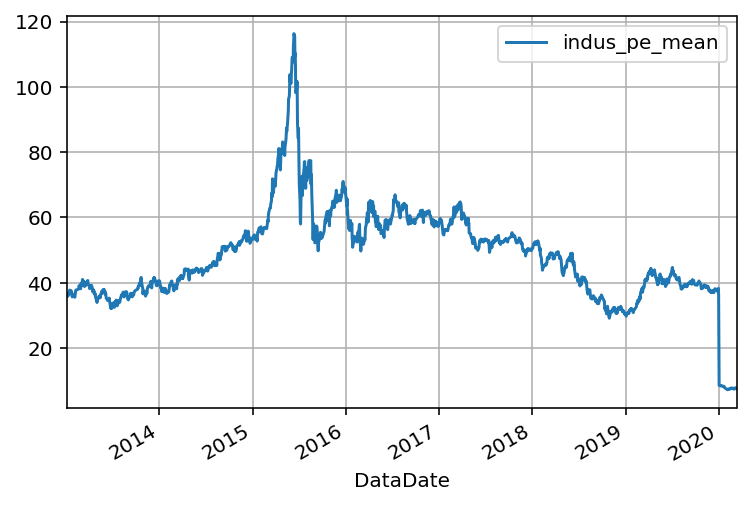

Empty DataFrame
Columns: []
Index: []

In [48]:
def indus_pe_analysis(df):
    df_indus = df.set_index("DataDate")
    df_indus.index = pd.to_datetime(df_indus.index)
    
    df_indus["indus_pe_mean"].plot()
    plt.grid()
    plt.legend()
    plt.show()

df_indus_pe_mean.groupby(["industry"]).apply(indus_pe_analysis)

In [22]:
#利用过去两年 PE中位数作为当前合理的 PE
df_PETTM=pd.read_csv(r"data/PETTM.csv",dtype={"DataDate":str})
df_indus=query_table("DailyBar",start_date='20120101',end_date='20200310',fields=["L1_INDUSTRY"])
df_indus["DataDate"] = df_indus["DataDate"].apply(str)
df_PETTM = df_PETTM.merge(df_indus,on=["sid","DataDate"])

def adj_by_indus_pe(df):
    indus_pe = np.nanmedian(df["S_VAL_PE_TTM"]) 
    df["S_VAL_PE_TTM"] = np.clip(df["S_VAL_PE_TTM"].values, 0,indus_pe*2)
    return df
groups = df_PETTM.groupby(["L1_INDUSTRY","DataDate"])
df_PETTM = apply_parallel(groups, adj_by_indus_pe).reset_index(drop=True)
df_PETTM = df_PETTM.sort_values(["sid","DataDate"])

def Rolling_Median(df):
    df["S_VAL_PE_TTM"]=df["S_VAL_PE_TTM"].fillna(method='bfill')
    df["pe_2y_rollingmedian"]=df["S_VAL_PE_TTM"].rolling(252*1).apply(lambda x:np.percentile(x,10))
    #df["pe_2y_rollingmedian"]=np.minimum(df["pe_2y_rollingmedian"].values,\
    #                                      df["S_VAL_PE_TTM"].values*1.5)
    return df

grouped=df_PETTM.groupby("sid")
df_PETTM_2y_rollingmedian=apply_parallel(grouped,Rolling_Median)
stock_pool_est_eps=pd.merge(stock_pool_est_eps,df_PETTM_2y_rollingmedian,on=["sid","DataDate"],how="left")

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    4.7s
[Parallel(n_jobs=16)]: Done 216 tasks      | elapsed:    5.2s
[Parallel(n_jobs=16)]: Done 1168 tasks      | elapsed:    6.8s
[Parallel(n_jobs=16)]: Done 2464 tasks      | elapsed:    9.5s
[Parallel(n_jobs=16)]: Done 4048 tasks      | elapsed:   13.1s
[Parallel(n_jobs=16)]: Done 5920 tasks      | elapsed:   17.1s
[Parallel(n_jobs=16)]: Done 8080 tasks      | elapsed:   20.9s
[Parallel(n_jobs=16)]: Done 10528 tasks      | elapsed:   25.4s
[Parallel(n_jobs=16)]: Done 13264 tasks      | elapsed:   30.8s
[Parallel(n_jobs=16)]: Done 16288 tasks      | elapsed:   37.2s
[Parallel(n_jobs=16)]: Done 19600 tasks      | elapsed:   45.1s
[Parallel(n_jobs=16)]: Done 23200 tasks      | elapsed:   52.8s
[Parallel(n_jobs=16)]: Done 27088 tasks      | elapsed:  1.1min
[Parallel(n_jobs=16)]: Done 31264 tasks      | elapsed:  1.2min
[Parallel(n_jobs=16)]: Done 35728 ta

In [ ]:
stock_pool_est_eps.head()

## 测试策略在单只股票下的具体表现

In [13]:
def Get_prices(daily_df):
    close=daily_df["S_DQ_ADJCLOSE"].values[0]
    date=daily_df["DataDate"].values[0]
    
    pe = np.nan
    prices=np.array([0,0,0,0],dtype=float)
    for i in range(4):
        try:
            reporting_period=str(int(date[0:4])+i-1)+"1231"
            con_est_eps=daily_df[daily_df["REPORTING_PERIOD"]==reporting_period]["con_est_eps"].values[0]
            pe=daily_df[daily_df["REPORTING_PERIOD"]==reporting_period]["pe_2y_rollingmedian"].values[0]
            prices[i]=con_est_eps*pe
        except IndexError as e:
            pass
        
    #填充第三年数据
    if prices[2]==0:
        prices[2]= prices[1]+(prices[1]-prices[0])
    
    #处理四年con_eps 非线性增长的情况
    if prices[0]>prices[1] and prices[1]<prices[2]:
        prices[0] = prices[1]-(prices[2]-prices[1])
    elif prices[1]>prices[2] and prices[0]<prices[2]:
        prices[1] = (prices[0]+prices[2])/2
    
    #填充第四年数据
    if prices[3] ==0:
        prices[3]=prices[2]+(prices[2]-prices[1])
    
        
    #进行平滑（向未来一年进行滚动）
    month , day =( int(date[4:6]), int(date[6:8]) )
    day_num = (month-1)*30 +day
    prices_smooth = np.array([0,0,0],dtype=float)
    for i in range(3):
        prices_smooth[i] = (prices[i]*(360-day_num)+prices[i+1]*day_num)/360
    
    prices_smooth.sort()
    return pd.DataFrame(data=[[prices_smooth[0],prices_smooth[1],prices_smooth[2],close,pe]],columns=["p0","p1","p2","close","pe_rollingmedian"])

def get_level(close,prices):        
    level=0
    benchmark=0
    for p in prices:
        if close<p:
            return level+(close-benchmark)/(p-benchmark)
        else:
            level = level+1
            benchmark = p
    if (prices[2]-prices[1])/prices[1]>0.1:
        return level+(close-benchmark)/(prices[2]-prices[1])
    else:
        return level+(close-benchmark)/(prices[1]*0.1)

def get_level_from_rolling_data(arr):
    current_close=arr[251,3]
    current_estprices=arr[251,0:3]
    
    close_series=arr[:,3]
    bottom_series=arr[:,0]
    middle_series = arr[:,1]
    ##params adjusting
    if np.sum(close_series<(bottom_series+middle_series)/2)/len(close_series)>0.80:
        current_estprices_adj = current_close/current_estprices[1]*current_estprices
    else:
        current_estprices_adj = current_estprices
    return get_level(current_close,current_estprices),get_level(current_close,current_estprices_adj)

def get_position(over_level):
    grid=np.linspace(1.0,3.7,5)
    position=np.linspace(1,0,6)

    count=0
    for i in grid:
        if over_level>i:
            count=count+1
        else:
            break
    return position[count]

def get_max_drawdown(arr):
    max_drawdown=0
    for i in range(len(arr)):
        cum_ret=np.cumprod(1+arr[i:])
        if (1 - np.min(cum_ret)) > max_drawdown:
            max_drawdown = 1 - np.min(cum_ret)
    return max_drawdown


In [8]:
#analyse the perfromance of the strategy on single stock
def Single_Stock_Analysis(df):
    """
    #this function is used to analysis the con_est_price versus the real_trading price 
    #,and use the timing strategy to get the right position(0-1) at each date，and then:
    #1.plot the close_price and the con_est_prices(p0,p1,p2)
    #2.calculate the over_level of the stock_price
    #3.plot the trading result of this stock(cumulative return of trading the stock)
    #4.calculate the indicator for the strategy ret
    """    
    sid=df["sid"][df.index[0]]
    
    #1.plot the close_price and the con_est_prices(p0,p1,p2)     
    df=df.groupby("DataDate").apply(Get_prices)
    df=df.reset_index().set_index("DataDate")
    del df["level_1"]
    df.index=pd.to_datetime(df.index)
    
    plt.xticks(rotation=90)
    plt.plot(df[["p0","p1","p2","close"]])
    plt.legend()
    plt.grid()
    plt.title(sid+" close_price and the con_est_prices")
    try:
        test_con_timing.savefig()
    except:
        pass
    plt.show()
    
    #2.plot the over_level of the stock_price   
    df["over_level"]=np.nan
    df["over_level_adj"] =np.nan 
    for i in range(251,len(df)):
        rolling_arr = df.iloc[np.arange(i-251,i+1)]
        df.iloc[i,5:7] = get_level_from_rolling_data(np.array(rolling_arr))
        
    df.to_csv(r"result/stk_est_eps/est_eps_{}.csv".format(sid),index_label="DataDate")
    #3.plot the trading result of this stock(cumulative return of trading the stock)
    df["position"]=df["over_level"].apply(get_position)
    df["position_adj"]=df["over_level_adj"].apply(get_position)
    open_price_adj["DataDate"]=pd.to_datetime(open_price_adj["DataDate"])
    df["change_rate"]=open_price_adj.set_index("sid").loc[sid].set_index("DataDate").pct_change().shift(-2)
    df["trading_profit_loss"]=df["position"]*df["change_rate"]
    df["trading_profit_loss_adj"]=df["position_adj"]*df["change_rate"]
    df["strategy_ret"]=np.cumprod(1+df["trading_profit_loss"].fillna(0))
    df["strategy_ret_adj"]=np.cumprod(1+df["trading_profit_loss_adj"].fillna(0))
    df["stock_ret"]=np.cumprod(1+df["change_rate"].fillna(0))
    

    plt.xticks(rotation=90)
    plt.plot(df["strategy_ret_adj"],label="strategy_ret_adj",color='tab:blue')
    plt.plot(df["strategy_ret"],label="strategy_ret",color='tab:green')
    plt.plot(df["stock_ret"],label="stock_ret",color='tab:red')
    plt.legend()
    plt.grid()
    plt.title(sid+" cumulative return of trading the stock")
    test_con_timing.savefig()
    plt.show()
    
    #4.calculate the indicator for the strategy ret
            
    indicator_df.loc[(sid,"stock"),"tot_return"] = df["stock_ret"].iloc[-1]-1
    indicator_df.loc[(sid,"strategy"),"tot_return"] = df["strategy_ret"].iloc[-1]-1
    indicator_df.loc[(sid,"strategy_adj"),"tot_return"] = df["strategy_ret_adj"].iloc[-1]-1
    indicator_df.loc[(sid,"stock"),"yearly_ret"] = np.power(df["stock_ret"].iloc[-1],252/len(df))-1
    indicator_df.loc[(sid,"strategy"),"yearly_ret"] = np.power(df["strategy_ret"].iloc[-1],252/len(df))-1
    indicator_df.loc[(sid,"strategy_adj"),"yearly_ret"] = np.power(df["strategy_ret_adj"].iloc[-1],252/len(df))-1
    indicator_df.loc[(sid,"stock"),"daily_volat"] = np.nanstd(df["change_rate"])
    indicator_df.loc[(sid,"strategy"),"daily_volat"] = np.nanstd(df["trading_profit_loss"])
    indicator_df.loc[(sid,"strategy_adj"),"daily_volat"] = np.nanstd(df["trading_profit_loss_adj"])
    indicator_df.loc[(sid,"stock"),"yearly_volat"] = np.nanstd(df["change_rate"])*np.sqrt(252)
    indicator_df.loc[(sid,"strategy"),"yearly_volat"] = np.nanstd(df["trading_profit_loss"])*np.sqrt(252)
    indicator_df.loc[(sid,"strategy_adj"),"yearly_volat"] = np.nanstd(df["trading_profit_loss_adj"])*np.sqrt(252)
    indicator_df.loc[(sid,"stock"),"sharpe"] = np.nanmean(df["stock_ret"]) / np.nanstd(df["stock_ret"])
    indicator_df.loc[(sid,"strategy"),"sharpe"] = np.nanmean(df["strategy_ret"]) / np.nanstd(df["strategy_ret"])
    indicator_df.loc[(sid,"strategy_adj"),"sharpe"] = np.nanmean(df["strategy_ret_adj"]) / np.nanstd(df["strategy_ret_adj"])
    indicator_df.loc[(sid,"stock"),"yearly_sharpe"] = indicator_df.loc[(sid,"stock"),"yearly_ret"] / indicator_df.loc[(sid,"stock"),"yearly_volat"]
    indicator_df.loc[(sid,"strategy"),"yearly_sharpe"] = indicator_df.loc[(sid,"strategy"),"yearly_ret"] / indicator_df.loc[(sid,"strategy"),"yearly_volat"]
    indicator_df.loc[(sid,"strategy_adj"),"yearly_sharpe"] = indicator_df.loc[(sid,"strategy_adj"),"yearly_ret"] / indicator_df.loc[(sid,"strategy_adj"),"yearly_volat"]
    indicator_df.loc[(sid,"stock"),"max_drawdown"] = get_max_drawdown(df["change_rate"].dropna().values)
    indicator_df.loc[(sid,"strategy"),"max_drawdown"] =  get_max_drawdown(df["trading_profit_loss"].dropna().values)
    indicator_df.loc[(sid,"strategy_adj"),"max_drawdown"] =  get_max_drawdown(df["trading_profit_loss_adj"].dropna().values)
    
    indicator_df_singlestock =pd.DataFrame(indicator_df.loc[sid],dtype=float).reset_index()
    fig = plt.figure(figsize=(8,3))
    ax = plt.subplot(111)
    ax.axis('off')
    ax.table(cellText=indicator_df_singlestock.round(4).values, colLabels=indicator_df_singlestock.columns, bbox=[0,0,1,1])
    plt.title("the judging indicator of strategy ({})".format(sid))
    test_con_timing.savefig(fig)
    plt.show()
    
    return df[['stock_ret','strategy_ret','strategy_ret_adj']]
    
    

In [ ]:
test_df = stock_pool_est_eps.groupby("sid").get_group("000001.SZ")
Single_Stock_Analysis(test_df)

/home/ywang/env/dev/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


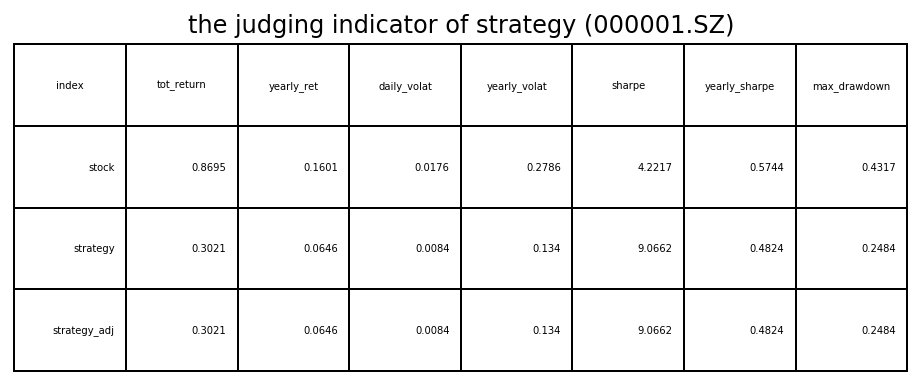

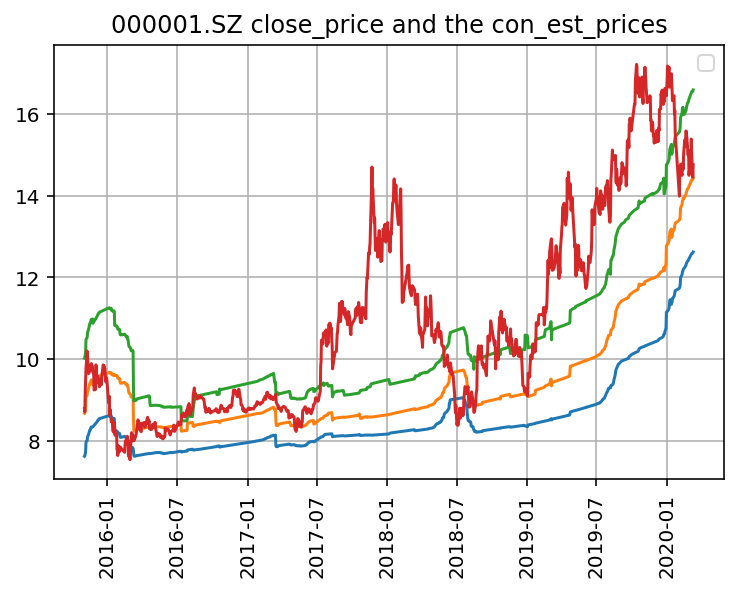

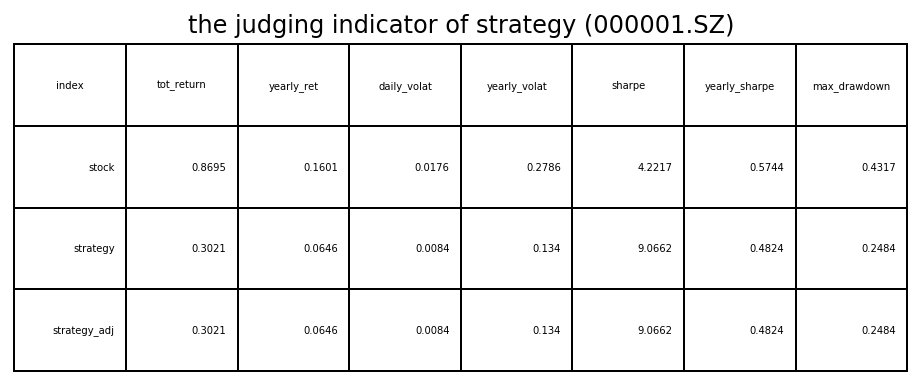

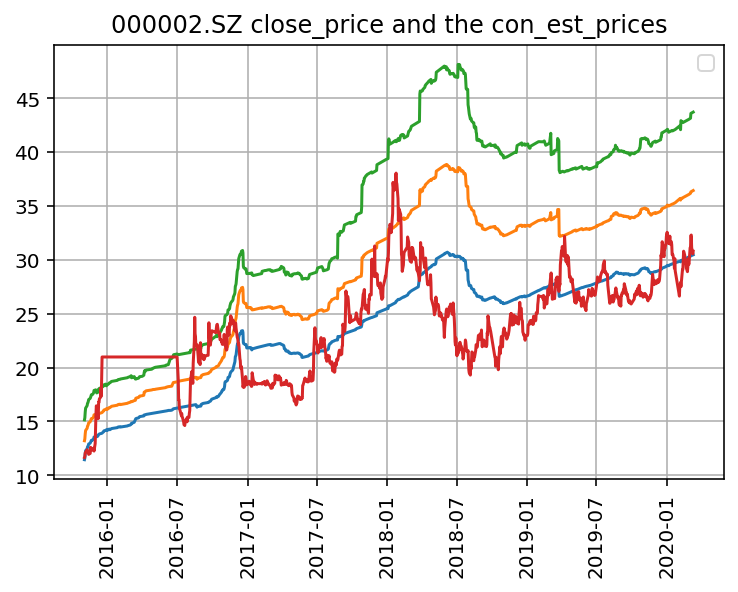

/home/ywang/env/dev/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in double_scalars
/home/ywang/env/dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in double_scalars


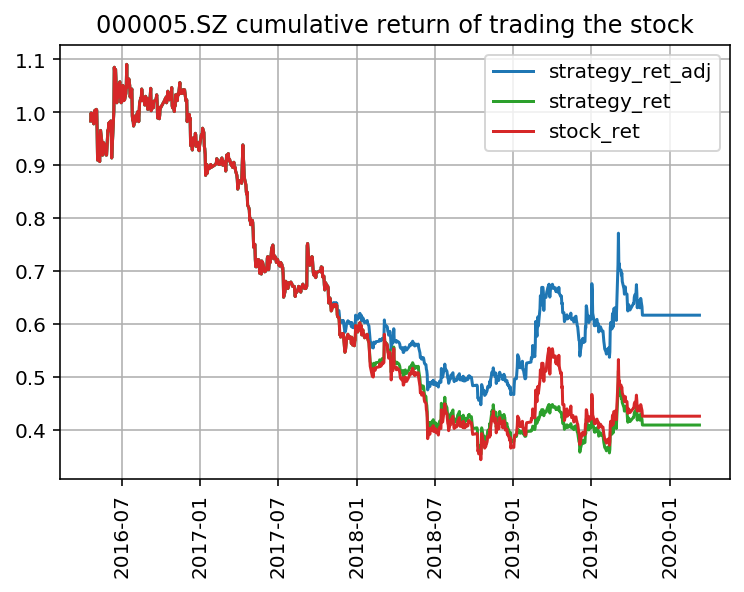

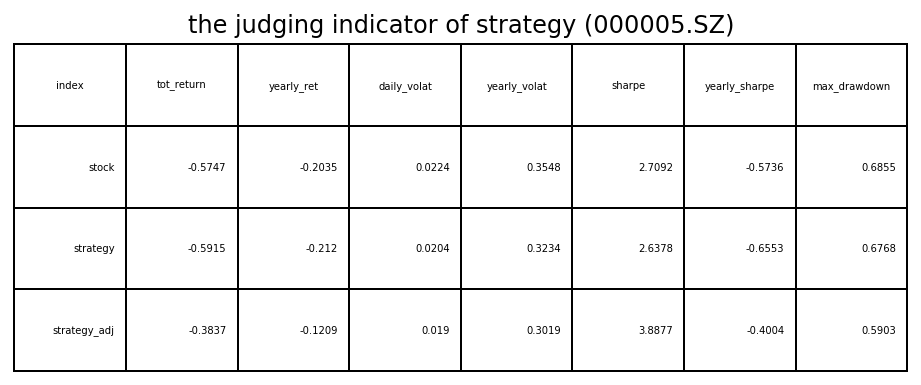

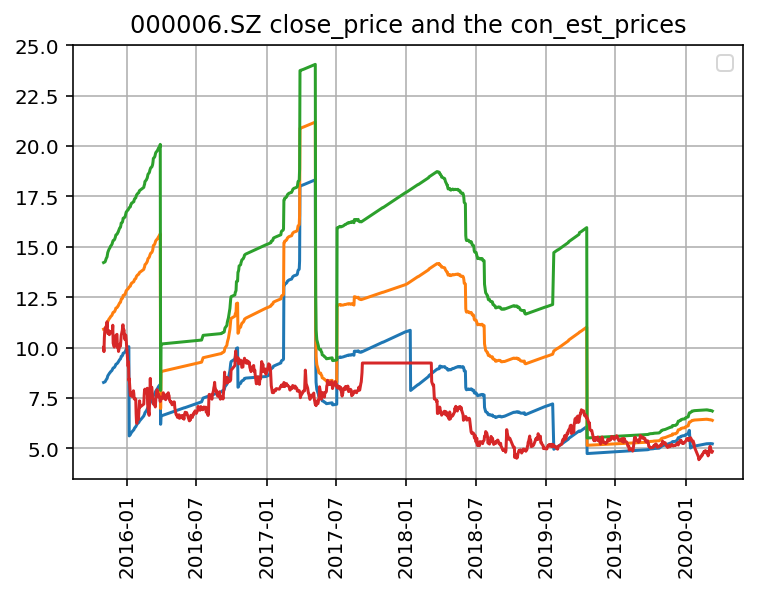

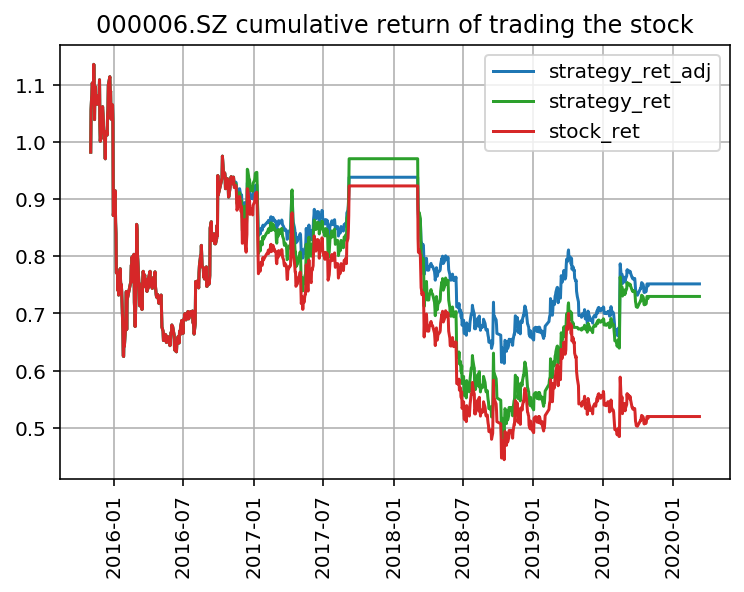

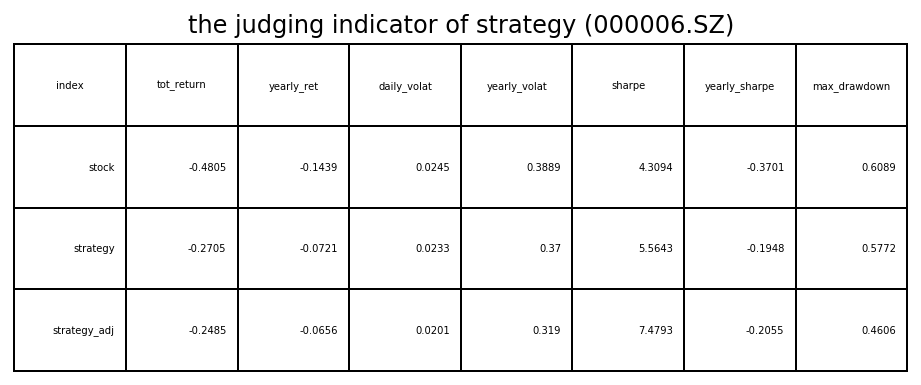

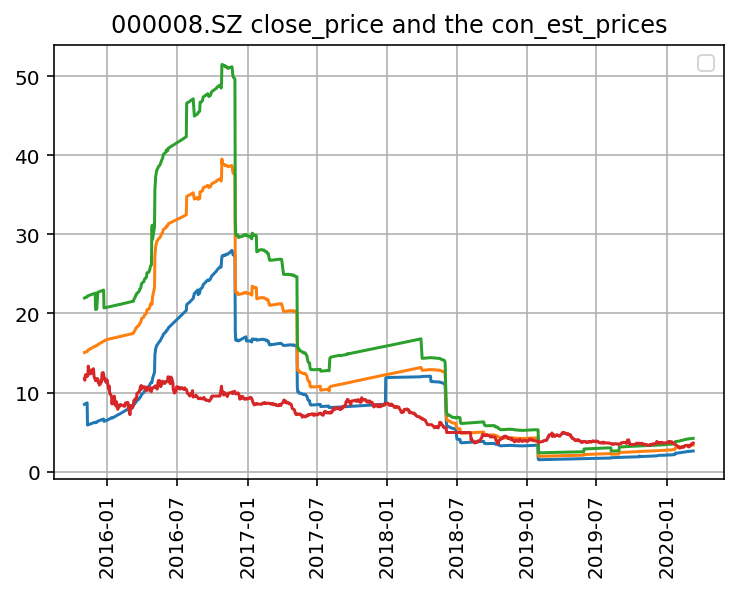

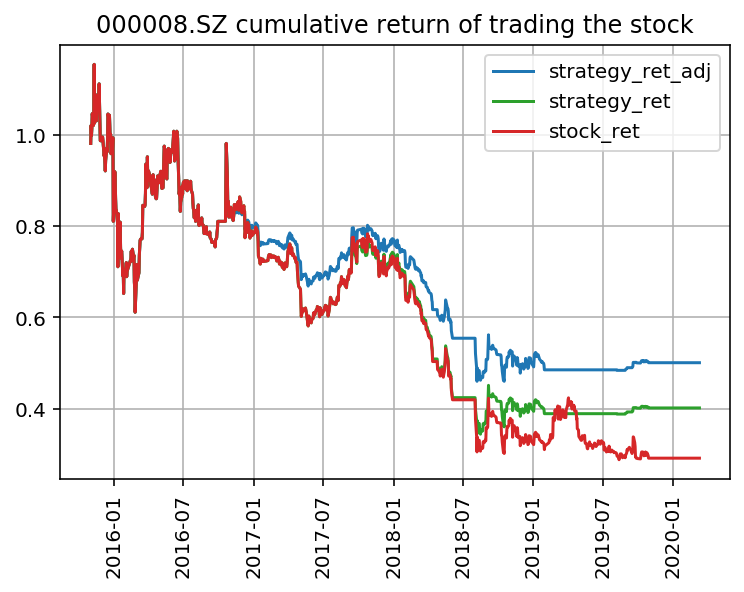

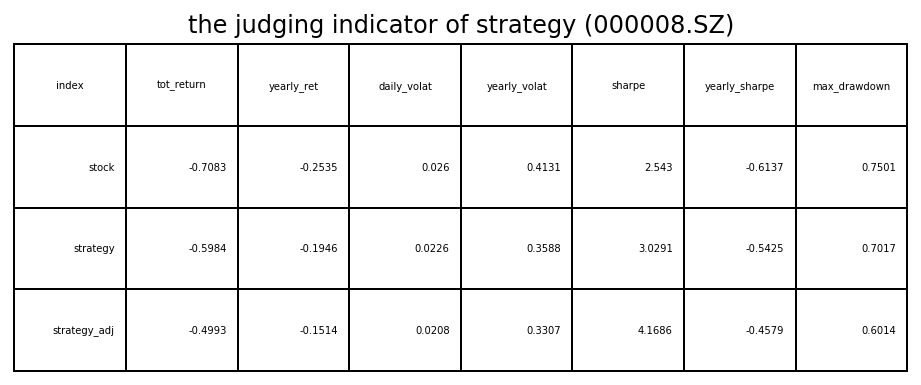

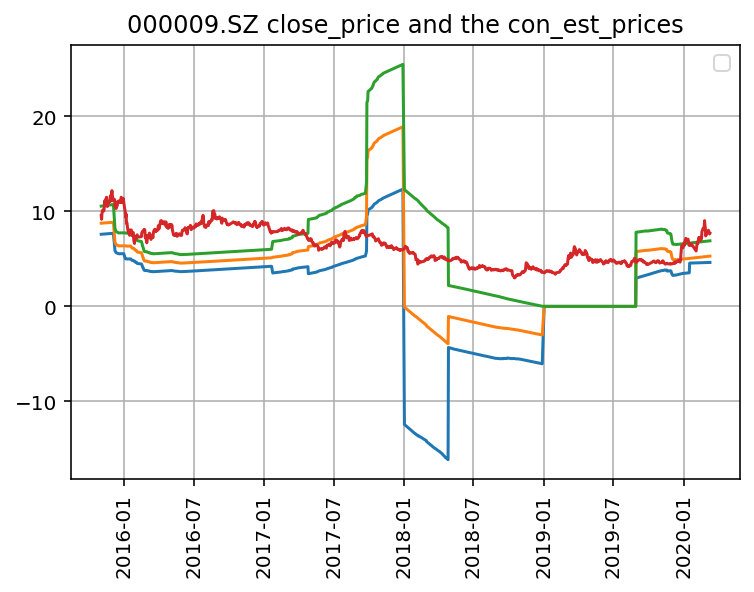

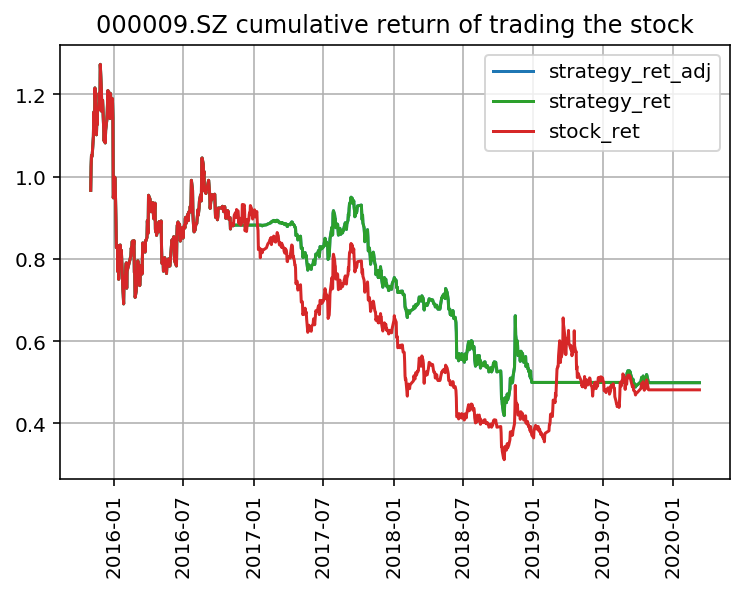

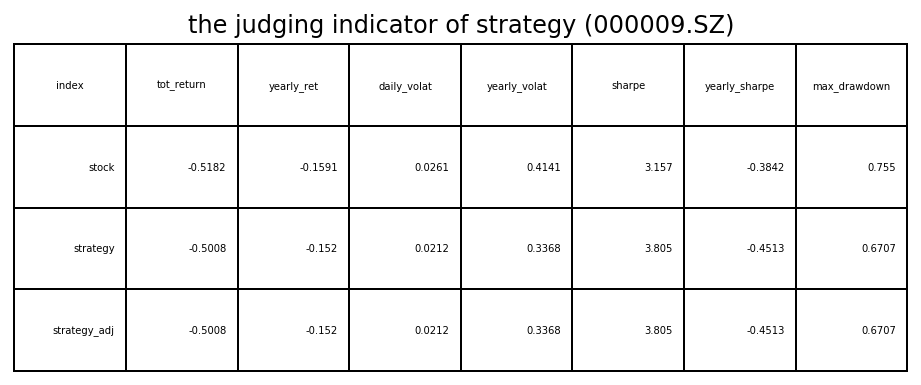

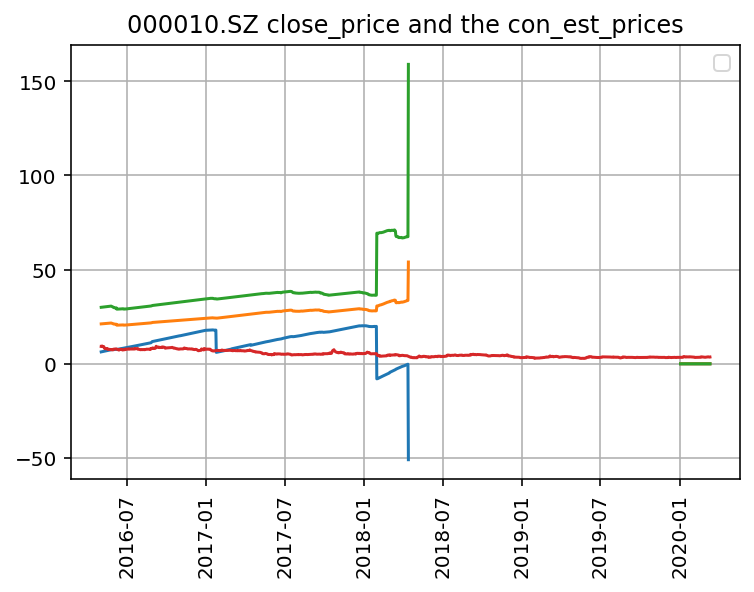

/home/ywang/env/dev/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in less


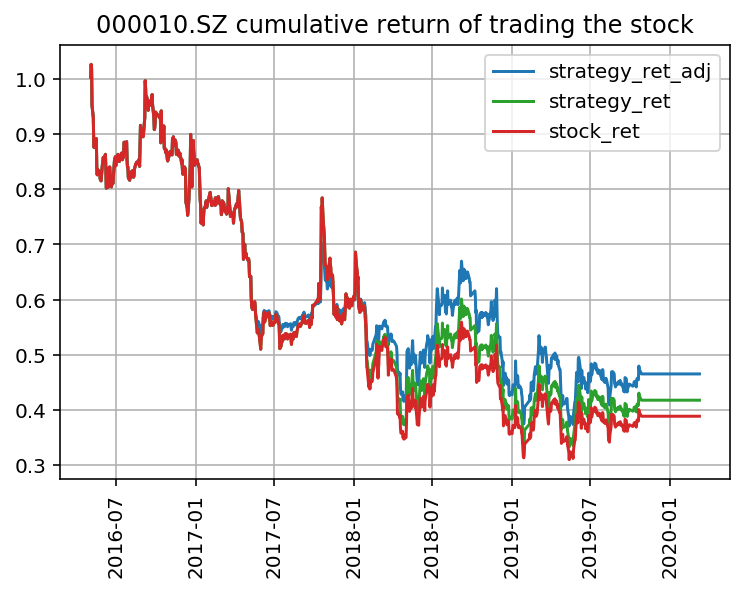

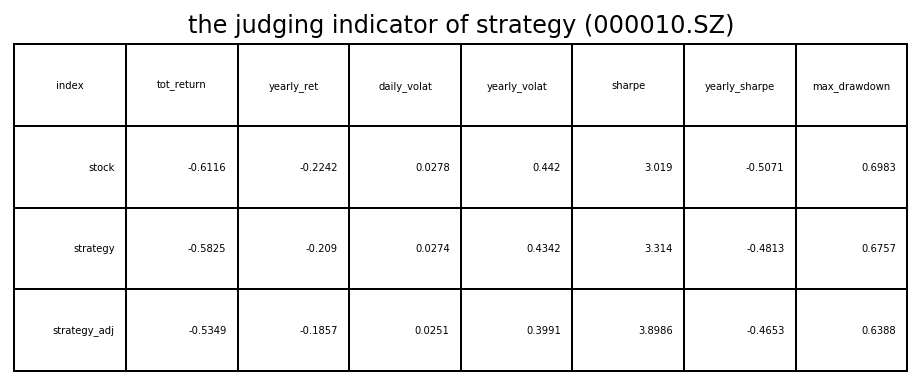

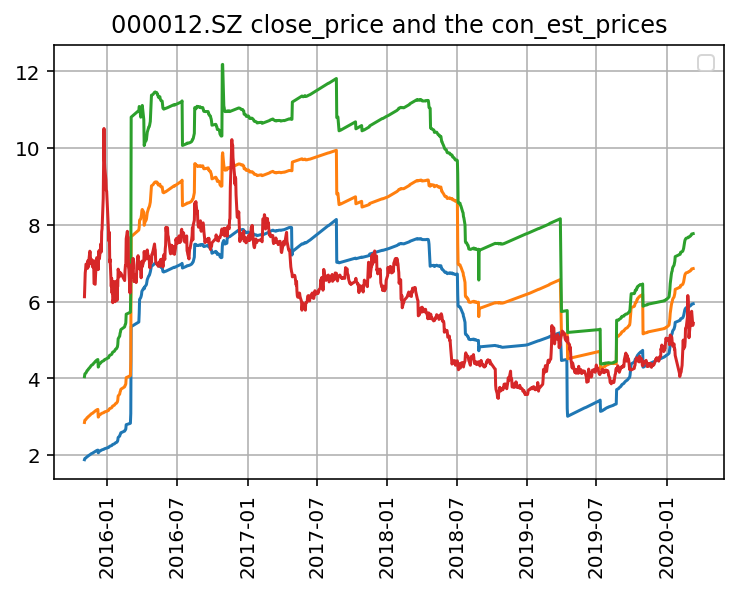

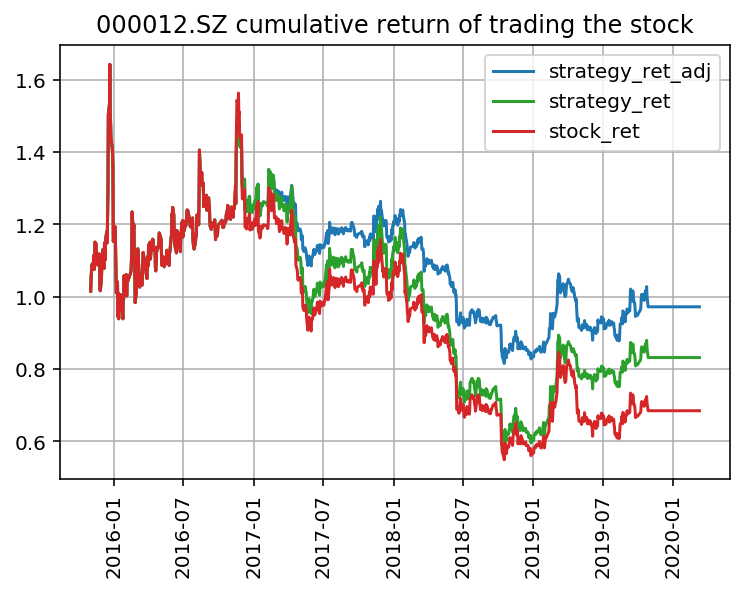

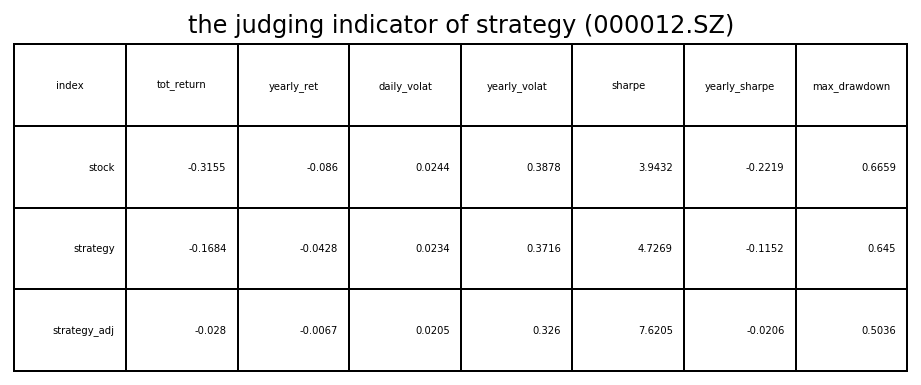

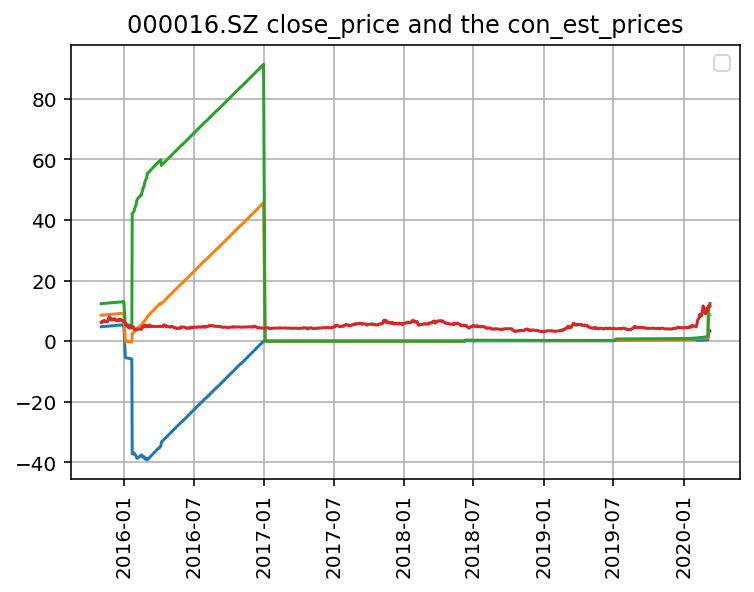

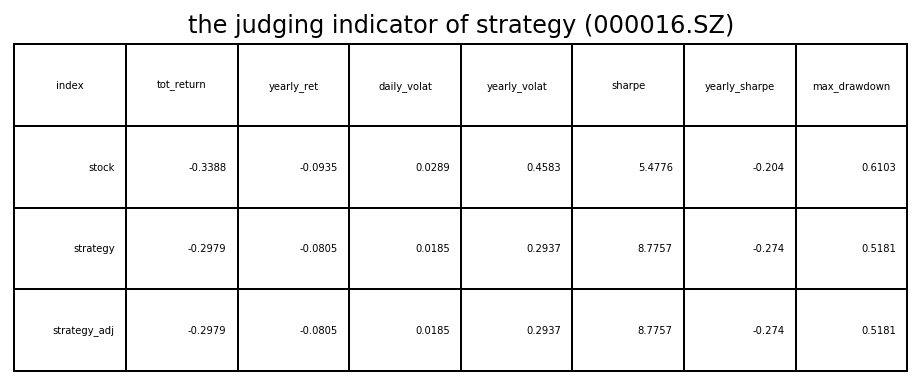

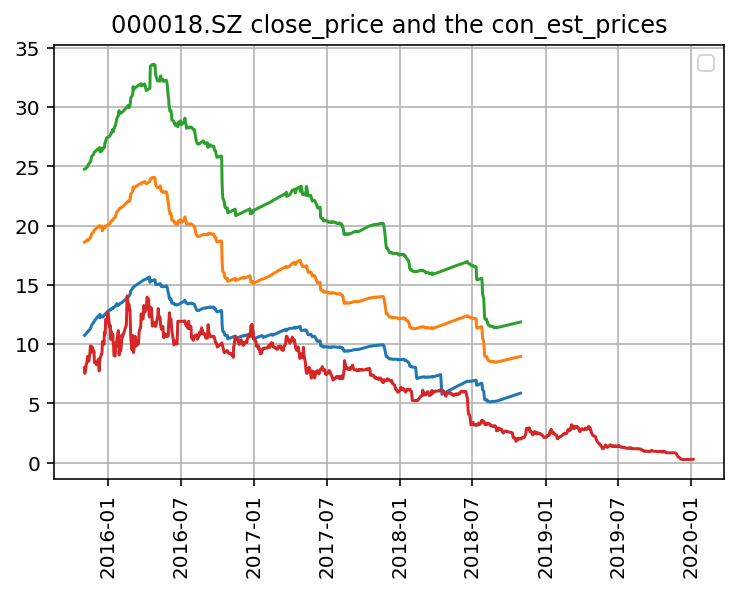

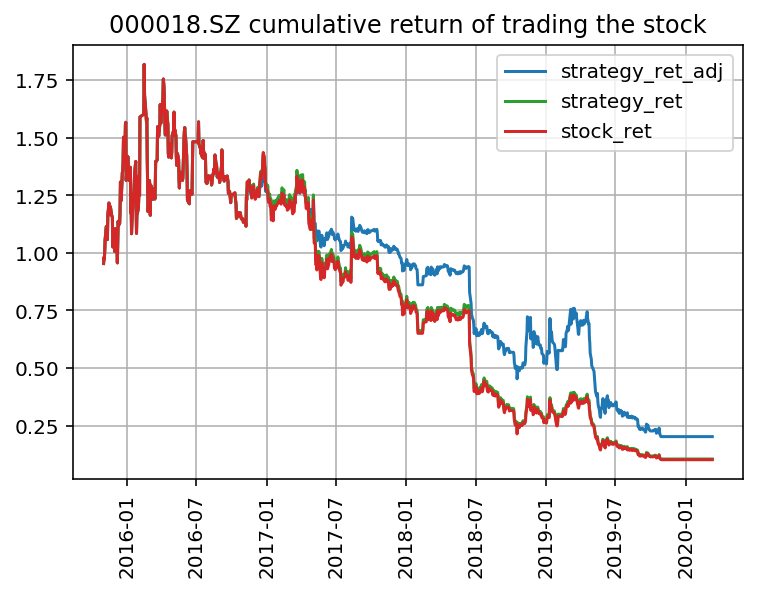

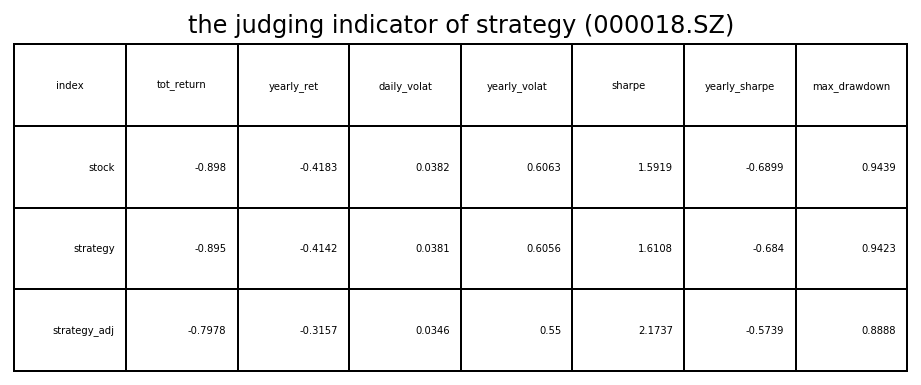

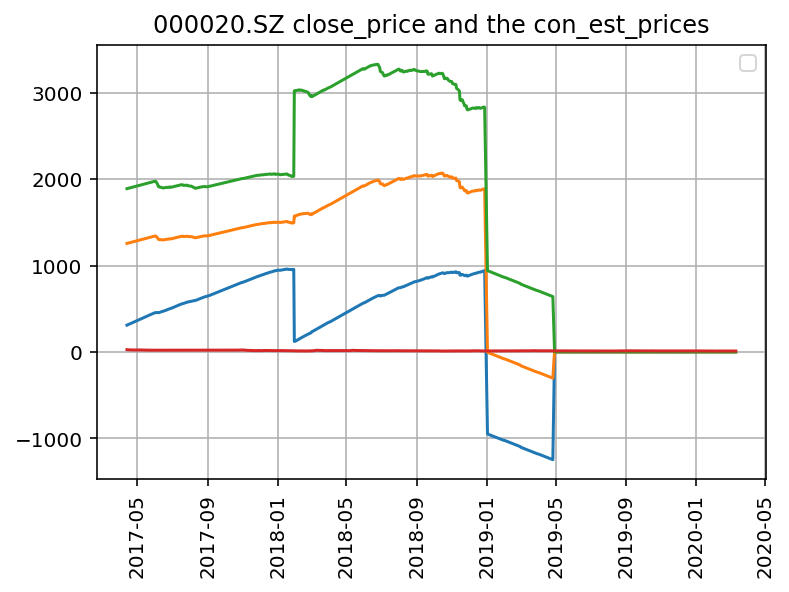


KeyboardInterrupt

Exception in thread QueueManagerThread:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ywang/env/dev/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py", line 674, in _queue_management_worker
    recursive_terminate(p)
  File "/home/ywang/env/dev/lib/python3.6/site-packages/joblib/externals/loky/backend/utils.py", line 28, in recursive_terminate
    _recursive_terminate_without_psutil(process)
  File "/home/ywang/env/dev/lib/python3.6/site-packages/joblib/externals/loky/backend/utils.py", line 53, in _recursive_terminate_without_psutil
    _recursive_terminate(process.pid)
  File "/home/ywang/env/dev/lib/python3.6/site-packages/joblib/externals/loky/backend/utils.py", line 94, in _recursive_terminate
    stderr=None
  File "/usr/local/lib/python

In [23]:
#过去两年 PE 中位数作为滚动 PE 值，回测时间 2015-01-01 到 2020-03-10
test_con_timing=PdfPages('result//test_overlevel_timing_stock_baima_pe10_smooth_v5.pdf')
indicator_df=pd.DataFrame(index=pd.MultiIndex.from_product([stk_ls,["stock","strategy","strategy_adj"]]),\
                          columns=["tot_return","yearly_ret","daily_volat","yearly_volat","sharpe","yearly_sharpe","max_drawdown"])
result_df=stock_pool_est_eps.groupby("sid").apply(Single_Stock_Analysis)
test_con_timing.close()

In [ ]:
def file_store(df):
    sid=df["sid"].iloc[0]
    
    result_df=df.groupby("DataDate").apply(Get_prices)
    result_df=result_df.reset_index().set_index("DataDate")
    del result_df["level_1"]
    result_df.index=pd.to_datetime(result_df.index)

    result_df["over_level"] = result_df[["p0","p1","p2","close"]].\
                                apply(lambda x:get_level(x[3],x[0:3]),axis = 1)
    
    result_df.to_csv(r"result/stk_est_eps/est_eps_{}.csv".format(sid),index_label="DataDate")

groups = stock_pool_est_eps.groupby("sid")
apply_parallel(groups,file_store)
    

In [ ]:
def get_max_drawdown(arr):
    max_drawdown=0
    for i in range(60,len(arr)):
        cum_ret=np.cumprod(1+arr[i:])
        if (1 - np.min(cum_ret)) > max_drawdown:
            max_drawdown = 1 - np.min(cum_ret)
    return max_drawdown

def get_indicator_df(sid,df):    
    indicator_df=pd.DataFrame(index=pd.MultiIndex.from_product([sid,["stock","strategy","strategy_adj"]]),\
                          columns=["tot_return","yearly_ret","daily_volat","yearly_volat","sharpe","yearly_sharpe","max_drawdown"])
    indicator_df.loc[(sid,"stock"),"tot_return"] = df["stock_ret"].iloc[-1]-1
    indicator_df.loc[(sid,"strategy"),"tot_return"] = df["strategy_ret"].iloc[-1]-1
    indicator_df.loc[(sid,"strategy_adj"),"tot_return"] = df["strategy_ret_adj"].iloc[-1]-1
    indicator_df.loc[(sid,"stock"),"yearly_ret"] = np.power(df["stock_ret"].iloc[-1],252/len(df))-1
    indicator_df.loc[(sid,"strategy"),"yearly_ret"] = np.power(df["strategy_ret"].iloc[-1],252/len(df))-1
    indicator_df.loc[(sid,"strategy_adj"),"yearly_ret"] = np.power(df["strategy_ret_adj"].iloc[-1],252/len(df))-1
    indicator_df.loc[(sid,"stock"),"daily_volat"] = np.nanstd(df["change_rate"])
    indicator_df.loc[(sid,"strategy"),"daily_volat"] = np.nanstd(df["trading_profit_loss"])
    indicator_df.loc[(sid,"strategy_adj"),"daily_volat"] = np.nanstd(df["trading_profit_loss_adj"])
    indicator_df.loc[(sid,"stock"),"yearly_volat"] = np.nanstd(df["change_rate"])*np.sqrt(252)
    indicator_df.loc[(sid,"strategy"),"yearly_volat"] = np.nanstd(df["trading_profit_loss"])*np.sqrt(252)
    indicator_df.loc[(sid,"strategy_adj"),"yearly_volat"] = np.nanstd(df["trading_profit_loss_adj"])*np.sqrt(252)
    indicator_df.loc[(sid,"stock"),"sharpe"] = np.nanmean(df["stock_ret"]) / np.nanstd(df["stock_ret"])
    indicator_df.loc[(sid,"strategy"),"sharpe"] = np.nanmean(df["strategy_ret"]) / np.nanstd(df["strategy_ret"])
    indicator_df.loc[(sid,"strategy_adj"),"sharpe"] = np.nanmean(df["strategy_ret_adj"]) / np.nanstd(df["strategy_ret_adj"])
    indicator_df.loc[(sid,"stock"),"yearly_sharpe"] = indicator_df.loc[(sid,"stock"),"yearly_ret"] / indicator_df.loc[(sid,"stock"),"yearly_volat"]
    indicator_df.loc[(sid,"strategy"),"yearly_sharpe"] = indicator_df.loc[(sid,"strategy"),"yearly_ret"] / indicator_df.loc[(sid,"strategy"),"yearly_volat"]
    indicator_df.loc[(sid,"strategy_adj"),"yearly_sharpe"] = indicator_df.loc[(sid,"strategy_adj"),"yearly_ret"] / indicator_df.loc[(sid,"strategy_adj"),"yearly_volat"]
    indicator_df.loc[(sid,"stock"),"max_drawdown"] = get_max_drawdown(df["change_rate"].dropna().values)
    indicator_df.loc[(sid,"strategy"),"max_drawdown"] =  get_max_drawdown(df["trading_profit_loss"].dropna().values)
    indicator_df.loc[(sid,"strategy_adj"),"max_drawdown"] =  get_max_drawdown(df["trading_profit_loss_adj"].dropna().values)
    
    return indicator_df

In [ ]:
test_con_timing=PdfPages("result//test_overlevel_timing_port_baima_pe30_smooth.pdf")

overall_ret=result_df.unstack(level=1).mean(axis=0).to_frame("ret").unstack(level=0)["ret"]

overall_ret.plot()
plt.title("stock portfolio test result")
test_con_timing.savefig()
overall_ret['change_rate']= overall_ret['stock_ret'].pct_change().fillna(0)
overall_ret['trading_profit_loss']= overall_ret["strategy_ret"].pct_change().fillna(0)
overall_ret['trading_profit_loss_adj']= overall_ret["strategy_ret_adj"].pct_change().fillna(0)

indicator_df=get_indicator_df(["portfolio"],overall_ret)
indicator_df_singlestock =pd.DataFrame(indicator_df.loc["portfolio"],dtype=float).reset_index()
fig = plt.figure(figsize=(8,3))
ax = plt.subplot(111)
ax.axis('off')
ax.table(cellText=indicator_df_singlestock.round(4).values, colLabels=indicator_df_singlestock.columns, bbox=[0,0,1,1])
plt.title("the judging indicator of strategy ({})".format("portfolio"))
test_con_timing.savefig(fig)
plt.show()

test_con_timing.close()

## con_eps zyyx数据

In [ ]:
df_con_eps_zyyx=pd.read_csv("data//con_eps_zyyx.csv")
df_con_eps_zyyx.sort_values(["stock_code","con_date"],inplace=True)

In [ ]:
temp_df=df_con_eps_zyyx[df_con_eps_zyyx["stock_code"]==651]
temp_df=temp_df[temp_df["con_date"]>='2017-03-01']
temp_df=temp_df[temp_df["con_year"]==2018]
temp_df.iloc[0:60]
plt.plot(pd.to_datetime(temp_df["con_date"].values),temp_df["con_eps"].values)
plt.grid()

## PE 走势

In [ ]:
temp_df=df_PETTM_2y_rollingmedian[df_PETTM_2y_rollingmedian["sid"] =='000568.SZ']
temp_df.sort_values('DataDate',inplace=True)
plt.plot(pd.to_datetime(temp_df["DataDate"].values),temp_df["S_VAL_PE_TTM"].values)
plt.plot(pd.to_datetime(temp_df["DataDate"].values),temp_df["pe_2y_rollingmedian"].values)

## con_eps 计算数据

In [ ]:
temp_df=stock_pool_est_eps[stock_pool_est_eps["sid"]=='000651.SZ']
temp_df=temp_df[temp_df["DataDate"]>='20170301']
temp_df=temp_df[temp_df["REPORTING_PERIOD"]=='20181231']
temp_df.iloc[0:60]
plt.plot(pd.to_datetime(temp_df["DataDate"].values),temp_df["con_est_eps"].values)
plt.grid()

In [ ]:
Single_Stock_Analysis(stock_pool_est_eps.groupby("sid").get_group("002050.SZ"))

In [ ]:
#通过滤波去除高频分量
from scipy import signal

def FFT(price_series):
    Wn = 0.4
    b, a = signal.butter(8, Wn, 'lowpass')   #配置滤波器 8 表示滤波器的阶数
    filtedData = signal.filtfilt(b, a, price_series)  #data为要过滤的信号
    return filtedData

In [ ]:
test_data=stock_pool_est_eps.iloc[0:40]['S_DQ_CLOSE']
plt.plot(test_data,label='original')
plt.plot(FFT(test_data),label='filtered')
plt.legend()
plt.show()